In [1]:
import glob

frac_imgs_path = glob.glob('./Scaphoid/Images/Fracture/*')
norm_imgs_path = glob.glob('./Scaphoid/Images/Normal/*')
frac_cord_path = glob.glob('./Scaphoid/Annotations/Fracture_Coordinate/*')
slice_path = glob.glob('./Scaphoid/Annotations/Scaphoid_Slice/*') # json 檔

print(len(frac_imgs_path), len(norm_imgs_path), len(frac_cord_path), len(slice_path))
# print(frac_imgs_path[:5])

120 120 120 240


In [2]:
import pandas as pd
import json
import numpy as np
import os
df = pd.DataFrame(columns = ['img_id' , 'x1', 'x2', 'y1', 'y2','cx1', 'cy1', 'cx2','cy2', 'angle'])
for i in slice_path:
    basename = os.path.basename(i)
    img_id = os.path.splitext(basename)[0]

    if os.path.exists('./Scaphoid/Annotations/Fracture_Coordinate/' + img_id + '.csv'): # 在 Fracture 的資料夾中
        with open('./Scaphoid/Annotations/Scaphoid_Slice/' + img_id + '.json') as f:
            clip_bbox = json.load(f)[0]['bbox']

        data_bbox = pd.read_csv('./Scaphoid/Annotations/Fracture_Coordinate/' + img_id + '.csv')
        df = df.append({'img_id':img_id ,
                        'x1':int(clip_bbox[0]), 
                        'x2':int(clip_bbox[1]), 
                        'y1':int(clip_bbox[2]), 
                        'y2':int(clip_bbox[3]),
                        'cx1':float(data_bbox['ctrx'][0])-float(data_bbox['width'][0])/2, 
                        'cy1':float(data_bbox['ctry'][0])-float(data_bbox['height'][0])/2, 
                        'cx2':float(data_bbox['ctrx'][0])+float(data_bbox['width'][0])/2,
                        'cy2':float(data_bbox['ctry'][0])+float(data_bbox['height'][0])/2, 
                        'angle':float(data_bbox['angle'][0])} , ignore_index=True)
print(len(df))
df.head()

120


,img_id,x1,x2,y1,y2,cx1,cy1,cx2,cy2,angle
0,00075616-AP0,751,794,873,945,33.0,82.5,83.0,105.5,42.0
1,00454212-LOB0,585,996,776,1189,47.5,92.5,124.5,121.5,-25.0
2,00454212-LOB20,425,982,545,1163,1.5,66.0,60.5,92.0,-25.0
3,00454212-LOB30,525,907,681,1118,26.5,109.5,101.5,132.5,-17.0
4,00454212-RAP0,829,994,1003,1158,58.0,86.0,140.0,112.0,31.0


In [3]:
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize, Flip,
                            Compose, GaussNoise)

# Albumentations
def get_train_transform():
    return Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_valid_transform():
    return Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


C:\Users\Ming\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Ming\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [4]:
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
class Clip_HandDataset(Dataset):
    def __init__(self, data_frame, transforms) -> None:
        super().__init__()
        self.df = data_frame
        self.images = data_frame['img_id']
        # print(len(self.images))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # print(idx, self.images[idx])
        # print(self.images[idx])
        image_filename = str(self.images[idx]) + '.bmp'
        # print(image_filename)
        if os.path.exists('./Scaphoid/Images/Fracture/' + image_filename): # 在 Fracture 的資料夾中
            image_arr = cv2.imread('./Scaphoid/Images/Fracture/' + image_filename, cv2.IMREAD_COLOR)
        else:
            print("Error Loading img")
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32) 
        image_arr /= 255.0

        image_id = self.images[idx]
        point = self.df[self.df['img_id'] == image_id]
        clip_bbox = point[['x1', 'x2', 'y1', 'y2']].values     
        image_arr = image_arr[clip_bbox[:, 1][0]:clip_bbox[:, 3][0], clip_bbox[:, 0][0]:clip_bbox[:, 2][0]]

        boxes = point[['cx1', 'cy1', 'cx2', 'cy2']].values
        boxes_angle = point[['angle']].values
        # print(boxes_angle[0,0])
        # area = (boxes[:, 3] - boxes[:, 2]) * (boxes[:, 1] - boxes[:, 0])

        # area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_id'] = torch.tensor(idx)
        # target['area'] = area
        target['iscrowd'] = iscrowd
        target['angle'] = torch.from_numpy(boxes_angle)
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels'],
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id


In [6]:
print(len(df))
train_data = Clip_HandDataset(df[:80], get_train_transform())
val = df[100:]
val.reset_index(inplace=True, drop=True)
val_data = Clip_HandDataset(val, get_valid_transform())

# batching
def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)


120


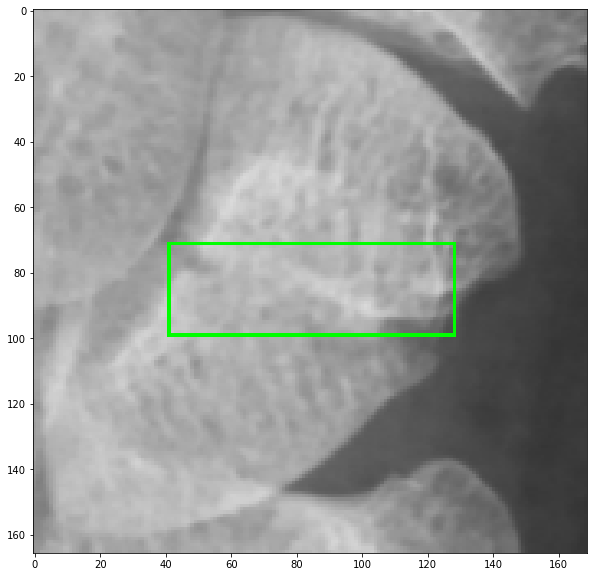

In [15]:
import matplotlib.pyplot as plt
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=1)
    plt.figure(figsize=(5,5))
    plt.imshow(image)

plot_img(val_data, 19)


In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [25]:
from lib import egine

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(num_classes=2)
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
num_epochs = 1

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     egine.train_one_epoch(model, optimizer, train_data_loader, device, epoch)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     egine.evaluate(model, valid_data_loader, device=device)

# print("That's it!")
# torch.save(model.state_dict(), 'engine_stage2bbox_resnet50_fpn.pth')


In [12]:
pred_model = get_model_instance_segmentation(num_classes=2)
pred_model.load_state_dict(torch.load('stage2bbox_resnet50_fpn.pth', map_location='cpu'))
# model.load_state_dict(torch.load('model_state.pth', map_location='cpu'))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pred_model.to(device) # For inference
pred_model.eval()


C:\Users\Ming\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
from tqdm import tqdm

pred_list =[]
for images, targets, image_ids in tqdm(valid_data_loader):
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    prediction = pred_model(images, targets)
    
    for i in prediction:
        pred_list.append(i)


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Ming\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 5/5 [03:46<00:00, 45.32s/it]


[[ 18.48748   59.84306   80.28414   84.474724]
 [ 14.283431  54.27203   77.74917   75.953316]
 [ 24.596975  87.12127  103.35542  107.04922 ]
 [ 11.110309  45.93361   71.66842   70.39246 ]
 [ 15.484468  67.78073   95.22166   92.48844 ]
 [ 20.723513  54.53266   67.74917   97.62542 ]]


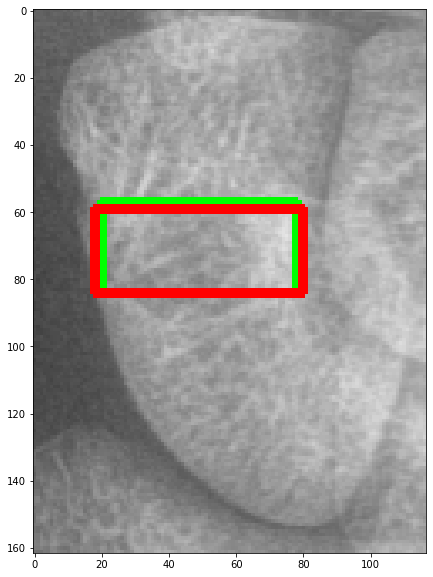

In [19]:
import matplotlib.pyplot as plt
# prediction1 = pred_list
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def predict_plot_img(data, idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    bb = pred_list[idx]['boxes'].detach().numpy()
    print(bb)
    for i in bb[:1]:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (255,0,0), thickness=2)
    # bb = prediction1[idx]['boxes'].detach().numpy()
    # for i in bb:
    #     cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,0,255), thickness=2)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

predict_plot_img(val_data,0)


In [1]:
def draw_rectangle(image, x1y1, x2y2, theta, color):
    centre = (int((x1y1[0]+x2y2[0])/2), int((x1y1[1]+x2y2[1])/2))
    width = int(x2y2[0] - x1y1[0])
    height= int(x2y2[1] - x1y1[1])
    
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    # print(R)
    p1 = [ + width / 2,  + height / 2]
    p2 = [- width / 2,  + height / 2]
    p3 = [ - width / 2, - height / 2]
    p4 = [ + width / 2,  - height / 2]
    p1_new = np.dot(p1, R)+ centre
    p2_new = np.dot(p2, R)+ centre
    p3_new = np.dot(p3, R)+ centre
    p4_new = np.dot(p4, R)+ centre
    img = cv2.line(image, (int(p1_new[0, 0]), int(p1_new[0, 1])), (int(p2_new[0, 0]), int(p2_new[0, 1])), color, 1)
    img = cv2.line(img, (int(p2_new[0, 0]), int(p2_new[0, 1])), (int(p3_new[0, 0]), int(p3_new[0, 1])), color, 1)
    img = cv2.line(img, (int(p3_new[0, 0]), int(p3_new[0, 1])), (int(p4_new[0, 0]), int(p4_new[0, 1])), color, 1)
    img = cv2.line(img, (int(p4_new[0, 0]), int(p4_new[0, 1])), (int(p1_new[0, 0]), int(p1_new[0, 1])), color, 1)

    return img

test_idx = 17
out = val_data.__getitem__(test_idx)
image = image_convert(out[0])
image = np.ascontiguousarray(image)
bb = out[1]['boxes'].numpy()
theta = out[1]['angle'].numpy()
print("Angle: ", theta)
for i in bb:
    cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=1)

for i in bb:
    image = draw_rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), theta, (0, 200, 0))

bb = pred_list[test_idx]['boxes'].detach().numpy() # predicted
for i in bb[:1]:
    image = draw_rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), theta, (200, 0, 0))
    cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (255,0,0), thickness=1)


plt.figure(figsize=(10,10))
plt.imshow(image)


NameError: name 'val_data' is not defined

In [ ]:
import pandas as pd
import json
import numpy as np
import os
test_df = pd.DataFrame(columns = ['img_id' , 'frac', 'x1', 'y1', 'x2', 'y2'])
for i in slice_path:
    basename = os.path.basename(i)
    img_id = os.path.splitext(basename)[0]
    # print(img_id)
    with open('./Scaphoid/Annotations/Scaphoid_Slice/' + img_id + '.json') as f:
            data_bbox = json.load(f)[0]['bbox']
    if os.path.exists('./Scaphoid/Annotations/Fracture_Coordinate/' + img_id + '.csv'): # 在 Fracture 的資料夾中
        test_df = test_df.append({'img_id':img_id ,
                        'frac':float(1), # '1' stands for fracture scaphoid
                        'x1':int(data_bbox[0]), 
                        'y1':int(data_bbox[2]), 
                        'x2':int(data_bbox[1]), 
                        'y2':int(data_bbox[3])} , ignore_index=True)

    else:
        test_df = test_df.append({'img_id':img_id ,
                        'frac':float(0),  # '0' stands for fracture scaphoid
                        'x1':int(data_bbox[0]), 
                        'y1':int(data_bbox[2]), 
                        'x2':int(data_bbox[1]), 
                        'y2':int(data_bbox[3])} , ignore_index=True)
test_df.head()

,img_id,frac,x1,y1,x2,y2
0,00075616-AP0,1.0,751,873,794,945
1,00169382 L 51F AP0,0.0,679,823,842,984
2,00230304 R 50F AP0,0.0,867,1007,943,1092
3,00293717 L 77M AP0,0.0,663,856,912,1091
4,00454212-LOB0,1.0,585,776,996,1189


In [ ]:
test_value = 9
print(test_value in test_df[test_df['frac']==1].index)
pos = 0
for idx, i in enumerate(test_df[test_df['frac']==1].index): 
    if test_value == i: 
        pos = idx
        break
print(pos)
print(test_df['img_id'][test_value] in df['img_id'].tolist())

True
6
True


,img_id,x1,x2,y1,y2,cx1,cy1,cx2,cy2,angle
6,00454212-ROB20,749,730,879,924,34.0,88.5,108.0,109.5,8.0


In [62]:
real = [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
pred = [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]

def score_computing(actual, predict):
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == 1 and predict[i] == 1:
            TP += 1
        elif actual[i] == 0 and predict[i] == 0:
            TN += 1
        elif actual[i] == 0 and predict[i] == 1:
            FP += 1
        elif actual[i] == 1 and predict[i] == 0:
            FN += 1
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * precision * recall / (precision + recall)
    return recall, precision, f1_score

recall, precision, f1_score = score_computing(real, pred)
print(recall, precision, f1_score)

0.5 0.6 0.5454545454545454
